In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
plt.rcParams['figure.figsize'] = [6, 3]
plt.rcParams['figure.dpi'] = 144
sns.set_style("white")

In [2]:
class SVM:
    def __init__(self, C=1, max_iter=1000, sigma='auto', kernel='rbf'):
        self.C = C
        self.max_iter = max_iter
        self.sigma = sigma
        self.kernel_mathod = kernel
        self.kernel_dict = {
            'rbf' : self.rbf_kernel,
            'linear' : self.linear_kernel
        }
        
    def rbf_kernel(self):
        for i in range(self.m):
            for j in range(self.m):
                self.kernel[i, j] = np.sum((self.data[i] - self.data[j]) ** 2)
        self.kernel = np.exp(-self.kernel / (2 * self.sigma ** 2))

        
    def linear_kernel(self):
        for i in range(self.m):
            for j in range(self.m):
                self.kernel[i, j] = np.dot(self.data[i], self.data[j])
        
    def update_SV_list(self):
        self.SV_list = {
            True : [],
            False : []
        }
        for i in range(self.m):
            self.SV_list[0 < self.alpha[i] < self.C].append(i)
            
    def get_alpha_2_index(self):
        if len(self.SV_list[False]) > 0:
            res = np.random.randint(len(self.SV_list[False]))
            for i in range(len(self.SV_list[False])):
                if (self.labels[i] * self.pred(i) <= 1 and self.alpha[i] < self.C or 
                    self.labels[i] * self.pred(i) >=1 and self.alpha[i] > 0 or
                    self.labels[i] * self.pred(i) == 1 and (self.alpha[i] == 0 or self.alpha[i] == self.C)):
                    res = i
            return res
        else:
            return np.random.randint(len(self.SV_list[True]))

#     def get_alpha_2_index(self):
#         if len(self.SV_list[False]) > 0:
#             res = np.random.randint(len(self.SV_list[False]))
#             for i in range(len(self.SV_list[False])):
#                 if (self.labels[i] * self.calc_Ei(i) <= -0.01 and self.alpha[i] < self.C or 
#                     self.labels[i] * self.calc_Ei(i) >= 0.01 and self.alpha[i] > 0 or
#                     -0.01 <= self.labels[i] * self.calc_Ei(i) <= 0.01 and (self.alpha[i] == 0 or self.alpha[i] == self.C)):
#                     res = i
#             return res
#         else:
#             return np.random.randint(len(self.SV_list[True]))
    
    def pred(self, i):
        return np.dot(self.alpha * self.labels, self.kernel[i])+ self.b
    
    def calc_Ei(self, i):
        return self.pred(i) - self.labels[i]
    
    def get_alpha_1_index(self, alpha_2_index):
        max_diff = 0
        alpha_1_index = 0
        # error_2 = self.calc_Ei(alpha_2_index)
        if len(self.SV_list[True]) > 0:
            for i in range(len(self.SV_list[True])):
                if i != alpha_2_index:
                    # error_1 = self.calc_Ei(i)
                    # diff = abs(error_1 - error_2)
                    diff = np.sum((self.data[i] - self.data[alpha_2_index]) ** 2)
                    if diff > max_diff:
                        max_diff = diff
                        alpha_1_index = i
        else:
            alpha_1_index = np.random.randint(self.m)
            while alpha_1_index == alpha_2_index:
                alpha_1_index = np.random.randint(self.m)        
        return alpha_1_index
    
    def get_L_H(self, a_2, a_1):
        if self.labels[a_2] != self.labels[a_1]:
            _diff = self.alpha[a_2] - self.alpha[a_1]
            L = max(0, _diff)
            H = min(self.C, self.C + _diff)
        else:
            _sum = self.alpha[a_2] + self.alpha[a_1]
            L = max(0, _sum - self.C)
            H = min(self.C, _sum)
        return L, H
  
    def update_2(self, alpha_2_index, alpha_1_index):
        j = alpha_2_index
        i = alpha_1_index
        L, H = self.get_L_H(j, i)
        eta = self.kernel[j, j] + self.kernel[i, i] - 2 * self.kernel[i, j]
        alpha_2_new = self.alpha[j] + self.labels[j] * (self.calc_Ei(i) - self.calc_Ei(j)) / eta
        alpha_2_new_c = np.clip(alpha_2_new, L, H)
        return alpha_2_new_c
    
    def update_1(self, alpha_2_index, alpha_1_index, alpha_2_old):
        j = alpha_2_index
        i = alpha_1_index
        alpha_1_new = self.alpha[i] + self.labels[i] * self.labels[j] * (alpha_2_old - self.alpha[j])
        return alpha_1_new
    
    def updata_b(self, alpha_2_index, alpha_1_index, error_2, error_1, alpha_2_old, alpha_1_old):
        j = alpha_2_index
        i = alpha_1_index
        E1 = error_1
        E2 = error_2
        diff_1 = self.alpha[i] - alpha_1_old
        diff_2 = self.alpha[j] - alpha_2_old
        b1 = self.b - E1 - self.labels[i] * diff_1 * self.kernel[i, i] - self.labels[j] * diff_2 * self.kernel[i, j]
        b2 = self.b - E2 - self.labels[i] * diff_1 * self.kernel[i, j] - self.labels[j] * diff_2 * self.kernel[j, j]
        # print(j, i, E1, E2, diff_1, diff_2, b1, b2)
        
        if 0 < self.alpha[i] < self.C:
            b = b1
        elif 0 < self.alpha[j] < self.C:
            b = b2
        else:
            b = (b1 + b2) / 2.0
        
        return b
        
    def smo(self):
        '''
        1. 选取一对alpha_2(第一个违反KKT) & alpha_1(不违反KKT的alpha对应的样本中，与alpha_2对应的样本，距离最远的样本)
        2. 求得alpha_2_new, 从而算出alpha_1_new
        3. 通过更新后的alpha更新b
        '''
        for iter_num in range(1, self.max_iter + 1):
            if iter_num % (self.max_iter / 5) == 0:
                print("%5d / %d iteration passed" % (iter_num, self.max_iter))
                self.CV_plot()
                self.plot()
                plt.show()

            self.update_SV_list()
            alpha_2_index = self.get_alpha_2_index()
            alpha_1_index = self.get_alpha_1_index(alpha_2_index)
            alpha_2_old = self.alpha[alpha_2_index]
            alpha_1_old = self.alpha[alpha_1_index]
            error_1 = self.calc_Ei(alpha_1_index)
            error_2 = self.calc_Ei(alpha_2_index)
            self.alpha[alpha_2_index] = self.update_2(alpha_2_index, alpha_1_index)
            self.alpha[alpha_1_index] = self.update_1(alpha_2_index, alpha_1_index, alpha_2_old)
            self.b = self.updata_b(alpha_2_index, alpha_1_index, error_2, error_1, alpha_2_old, alpha_1_old)
            # print(alpha_1_index, alpha_2_index, alpha_1_old, alpha_2_old, error_1, error_2, self.b)
        print("Training Process Finished")
      
    def rbf_pred(self, s_v, X):
        m = s_v.shape[0]
        res = np.zeros(m)
        for i in range(m):
            res[i] = np.sum((s_v[i] - X)**2)
        res = np.exp(-res / 2 / self.sigma**2)
        return res
    
    def test(self, test_data, test_label):
        s_v_index = (self.alpha > 0) # & (self.alpha < self.C)
        s_v = self.data[s_v_index]
        s_v_label = self.labels[s_v_index]
        s_v_alpha = self.alpha[s_v_index]
        m = test_data.shape[0]
        error_count = 0
        for i in range(m):
            w = self.rbf_pred(s_v, test_data[i])
            pred = np.dot(w, s_v_alpha * s_v_label) + self.b
            # print(test_data[i],'=>',pred)
            if np.sign(pred) != np.sign(test_label[i]):
                error_count += 1
        print('test accuracy: ', 1 - error_count / len(test_data))
    
    def plot(self):
        SV_1 = [[], []]
        SV_2 = [[], []]
        mid_1 = [[], []]
        mid_2 = [[], []]
        other_1 = [[], []]
        other_2 = [[], []]
        for i in range(self.m):
            plt.text(self.data[i][0], self.data[i][1], "%.2f" % self.alpha[i], color='green', fontsize=12)
            
            if self.alpha[i] != 0 and self.alpha[i] < self.C:
                if self.labels[i] == 1:
                    SV_1[0].append(self.data[i][0])
                    SV_1[1].append(self.data[i][1])
                else:  # -1
                    SV_2[0].append(self.data[i][0])
                    SV_2[1].append(self.data[i][1])
            elif self.alpha[i] == self.C:
                if self.labels[i] == 1:
                    mid_1[0].append(self.data[i][0])
                    mid_1[1].append(self.data[i][1])
                else:  # -1
                    mid_2[0].append(self.data[i][0])
                    mid_2[1].append(self.data[i][1])
            elif self.labels[i] == 1:
                other_1[0].append(self.data[i][0])
                other_1[1].append(self.data[i][1])
            else:  # -1
                other_2[0].append(self.data[i][0])
                other_2[1].append(self.data[i][1])
        plt.scatter(SV_1[0], SV_1[1], s=60, c='red', marker=r'$\bigodot$')
        plt.scatter(SV_2[0], SV_2[1], s=60, c='blue', marker=r'$\bigodot$')        
        plt.scatter(mid_1[0], mid_1[1], s=30, c='red', marker='s')
        plt.scatter(mid_2[0], mid_2[1], s=30, c='blue', marker='s')
        plt.scatter(other_1[0], other_1[1], s=30, c='red', marker='o')
        plt.scatter(other_2[0], other_2[1], s=30, c='blue', marker='o')
    
    def CV_plot(self):
        x_min = self.data[:, 0].min()
        x_max = self.data[:, 0].max()
        y_min = self.data[:, 1].min()
        y_max = self.data[:, 1].max()
        
        s_v_index = (self.alpha > 0)
        s_v = self.data[s_v_index]
        s_v_label = self.labels[s_v_index]
        s_v_alpha = self.alpha[s_v_index]
        
        # for i in np.arange()
        for i in np.arange(x_min,x_max, (x_max-x_min)/60):
            for j in np.arange(y_min,y_max, (y_max-y_min)/30):
                w = self.rbf_pred(s_v, np.array([i, j]))
                pred = np.dot(w, s_v_alpha * s_v_label) + self.b
                # print("(%.2f,%.2f)=>%.2f" % (i, j, pred))
                if pred > 0:
                    plt.scatter(i, j, color='red',s=10, marker='s')
                else:
                    plt.scatter(i, j, color='blue', s=10, marker='s')
                
    def train(self, data, label):
        self.b = 0
        self.data = np.array(data)
        self.labels = np.array(label)
        self.m, self.n = data.shape
        self.kernel = np.zeros((self.m, self.m))
        self.sigma = (1 / self.m) if self.sigma == 'auto' else self.sigma
        self.alpha = np.zeros(self.m)
        self.kernel_dict[self.kernel_mathod]()
        #self.rbf_kernel()
        self.SV_list = {
            True : [],
            False : []
        }
        self.smo()
        self.test(self.data, self.labels)
        # self.CV_plot()

In [3]:
data_ori = pd.read_csv('watermelon_4.0.csv', header=None)
data, label = data_ori.iloc[:, :-1], data_ori.iloc[:, -1]

   20 / 100 iteration passed


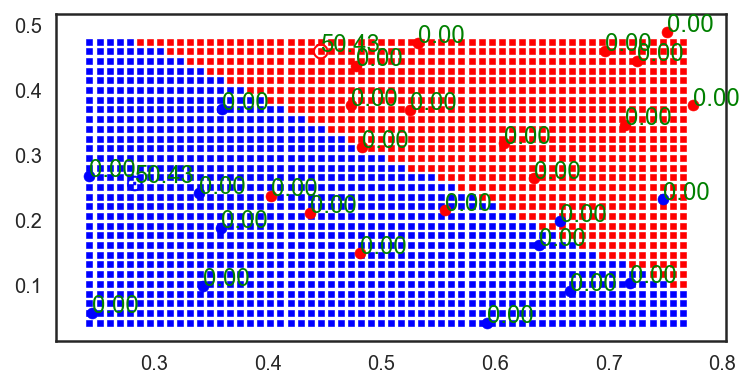

   40 / 100 iteration passed


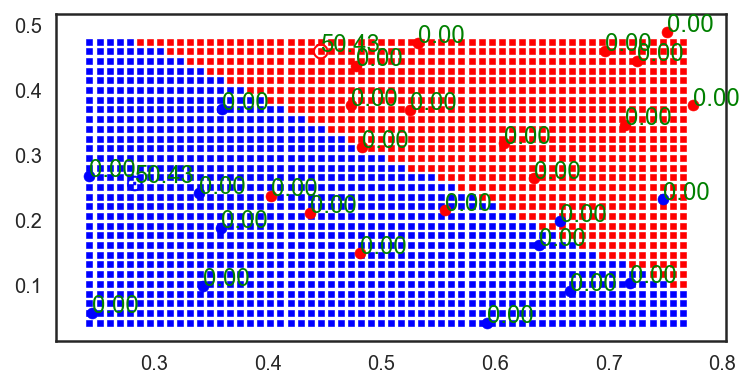

   60 / 100 iteration passed


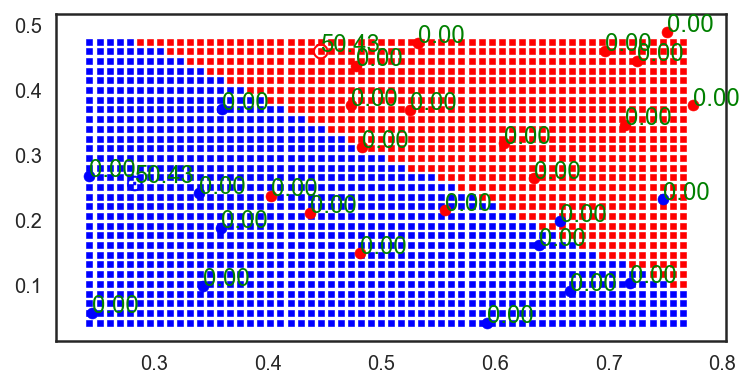

   80 / 100 iteration passed


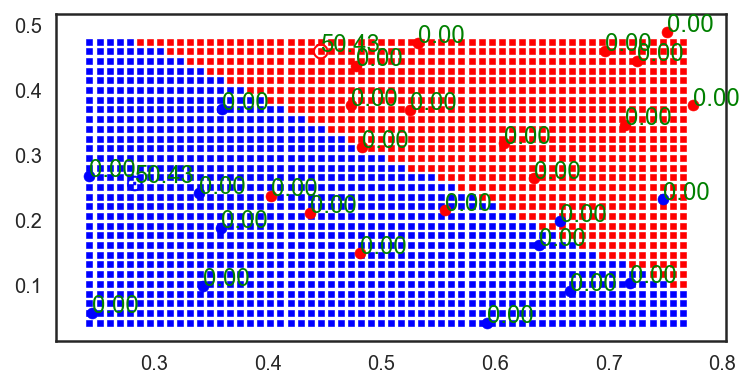

  100 / 100 iteration passed


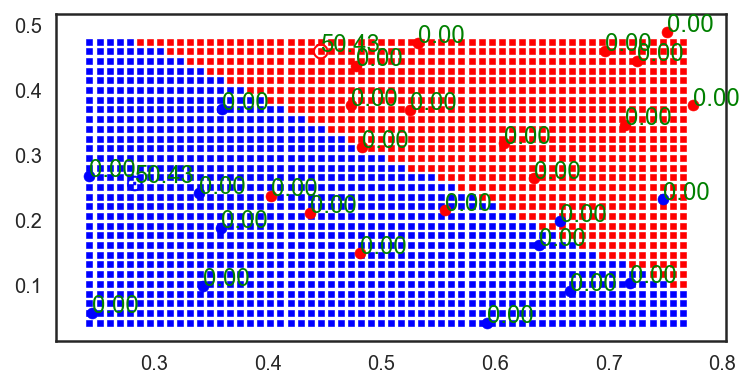

Training Process Finished
test accuracy:  0.7666666666666666


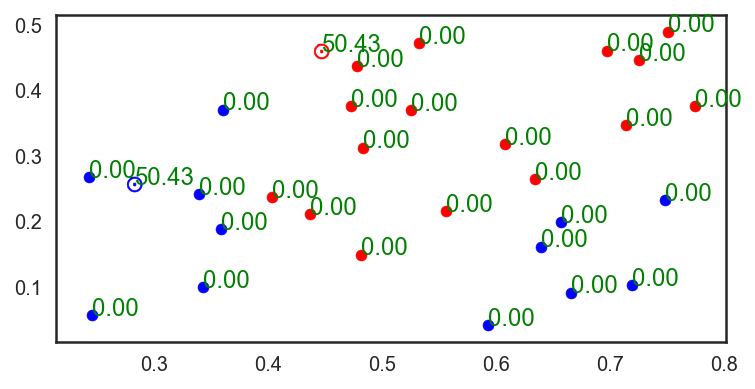

In [9]:
svm = SVM(C=200, max_iter=100, sigma=1.3, kernel='rbf')
svm.train(data, label)
svm.plot()
# svm.test(data, label)